In [41]:
%pip install --upgrade anomalytics
%pip list

In [42]:
import anomalytics as atics
import pandas as pd
import numpy as np

<h1 align=center><strong>Extremely Large Anomaly Detection</strong></h1>

This is just a proof of concept to walk you through `anomalytics`, enjoy 😎

## Content

1. ### [Data Generation](#data-generation)
2. ### [Detector Initialization](#pot-detector)
3. ### [Time Window: T0, T1, T2](#time-window)
4. ### [Peaks Over Threshold](#pot)
5. ### [Fitting](#fit)
6. ### [The Detection](#detection)
7. ### [Evaluation](#eval)
8. ### [Send Notification!](#notification)
9. ### [Restart Detection for Extremely Low Anomalies](#low-anomaly)

<h1 id="data-generation"><strong>Data Generation</strong></h1>

For the purpose of simplicity, let's generate dataset from NumPy random generator.

P. S. Xanr, GAM, and ADOBE are actual company names. They own the biggest savviest programmatic advertisement server. When you click cookier, your data is being auctioned and within 0.01, it is sold by the highest bidder 🤯🚀

In [43]:
np.random.seed(seed=42)

data_size = 365 * 3 * 60

df = pd.DataFrame(
    data={
        "datetime": pd.date_range(end="2023-12-03 00:00:00", periods=data_size, freq="T"),
        "xandr": np.random.normal(50, 5, data_size),
        "gam": np.random.normal(72, 8, data_size),
        "adobe": np.random.normal(39, 13, data_size),
    }
)
df.head()

,datetime,xandr,gam,adobe
0,2023-10-18 09:01:00,52.483571,71.021131,35.681915
1,2023-10-18 09:02:00,49.308678,73.651996,60.347246
2,2023-10-18 09:03:00,53.238443,65.690813,48.120805
3,2023-10-18 09:04:00,57.615149,80.944393,59.550775
4,2023-10-18 09:05:00,48.829233,76.445099,26.710413


<h1 id="pot-detector"><strong>POT Detector - Peaks Over Threshold</strong></h1>

The Peaks Over Threshold (POT) method is a statistical approach used in extreme value theory to model and estimate the probability of extreme events, such as significant financial losses or rare environmental phenomena. This method focuses on the tail of the distribution, using only the data points that exceed a specified threshold, which are considered to be the "peaks" or extreme values.

By fitting a Generalized Pareto Distribution (GPD) to these peaks, the POT method provides a way to estimate the likelihood and magnitude of extreme events beyond the chosen threshold. Read more about some concepts used in the implementation of `anomalytics` detector object:

* [Extreme Value Theory](https://en.wikipedia.org/wiki/Extreme_value_theory)
* [Generalized Pareto Distribution (GPD)](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution)
* [Extreme Value Theory Paper (Sorry no author's name)](http://www.iam.fmph.uniba.sk/institute/jurca/qrm/Chapter4.pdf)

In [44]:
pot_detector = atics.get_detector(
    method="POT",
    dataset=df,
    anomaly_type="high"
)

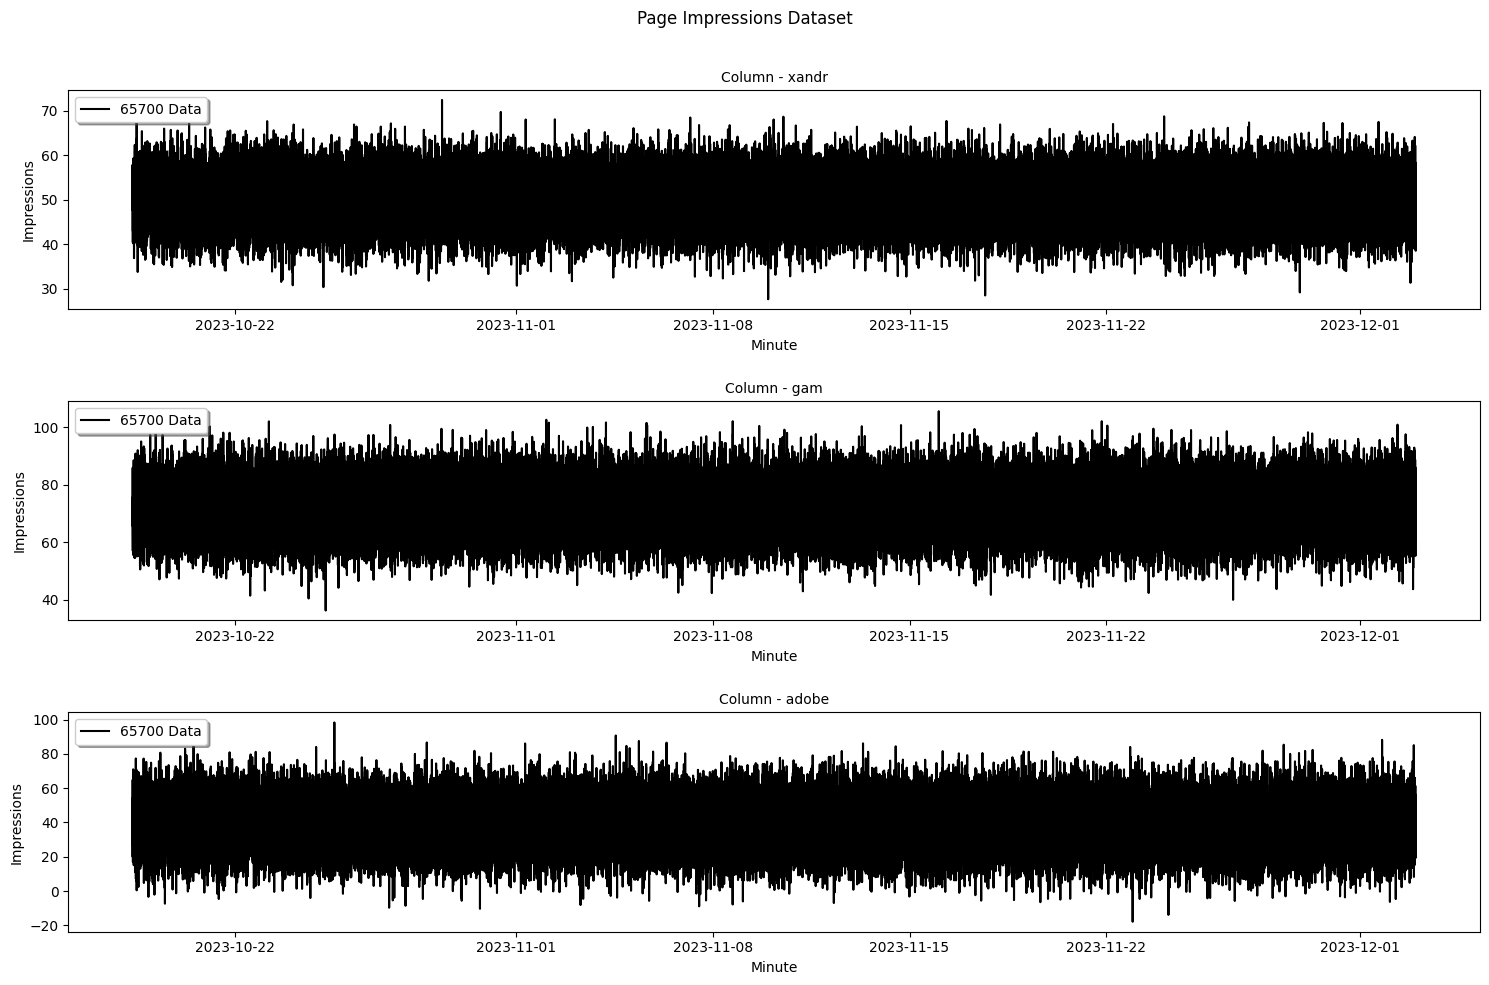

In [45]:
pot_detector.plot(ptype="line-dataset-df", title=f"Page Impressions Dataset", xlabel="Minute", ylabel="Impressions", alpha=1.0)

<h1 id="time-window"><string>Wimt Window: T0, T1, T2</strong></h1>

There are many concepts that can be used to support the application of POT method. `anomalytics` utilises the concept of 3 division window that was proposed by Alessandro Dolci, my project's supervisor at my work place at National Media & Technology of Axel Spriner SE. I really love the concept and thus implemented it into `anomalytics`.

### T0

T0 can be seen as the real "past" time period that can teach us about the behaviour of the data in our dataset. This capability is due to the idea that T0 should always hold the most days between the 3 time windows. The concrete use of T0 is to separate the super large values from the normally large values by using a dynamic time window expansion in our dataset to calculate the quantile for each cell/data point. This is called the threshold of POT and will be used to extract the exceedances.

### T1

T1 is the middle time period that is used to calculate the anomaly threshold after we fit the data points, starting T1 until T2, into the generalized pareto distribution to calculate the anomaly score which is

$\text{Inverted P-Value }=\frac{1}{1-CDF(\text{c}, \text{ loc}, \text{ scale})}$

### T2

T2 is the end time window that consists the "present" day. Depending on your use case, you might want the T2 to contain the least percentages of the total rows of the dataset. However, in production, it is only logical to use 1 row of T2 time window to represent the present time.

For the demo sake, we will use 10% of T2, so it looks cool when I generate the DataFrame and plots 😂


In [46]:
pot_detector.reset_time_window(
    analysis_type="historical",
    t0_pct=0.65,
    t1_pct=0.25,
    t2_pct=0.1
)

In [47]:
print("T0:", pot_detector.t0)
print("T1:", pot_detector.t1)
print("T2:", pot_detector.t2)

T0: 42705
T1: 16425
T2: 6570


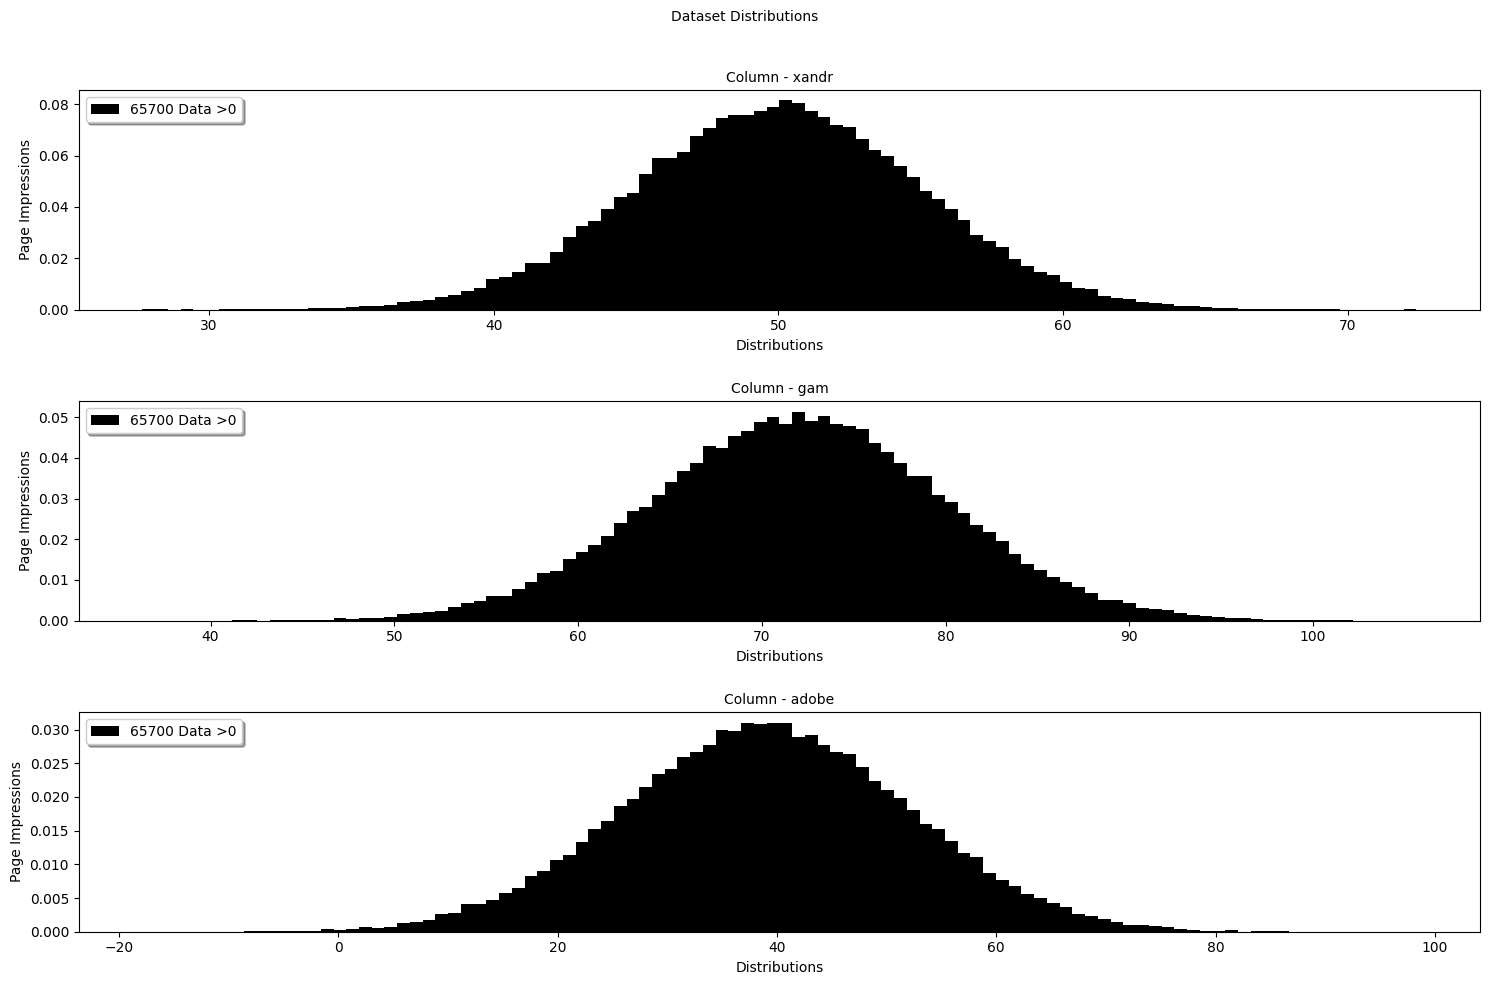

In [48]:
pot_detector.plot(ptype="hist-dataset-df", title="Dataset Distributions", xlabel="Distributions", ylabel="Page Impressions", alpha=1.0, bins=100)

<h1 id="pot"><strong>Peaks Over Threshold</strong></h1>

As the name suggested, The Peaks (also called **exceedances**) are the super large or small data points that have the potential to be the anomalies. This can be extracted with so many strategy, but in `anomalytics`, I use the NumPy quantile calculation with expanding window of T0.

In [49]:
pot_detector.get_extremes(q=0.95)
pot_detector.exceedance_thresholds.head(20)

,xandr,gam,adobe,datetime
0,58.224653,85.177029,60.362306,2023-10-18 09:01:00
1,58.224653,85.177029,60.362306,2023-10-18 09:02:00
2,58.224653,85.177029,60.362306,2023-10-18 09:03:00
3,58.224653,85.177029,60.362306,2023-10-18 09:04:00
4,58.224653,85.177029,60.362306,2023-10-18 09:05:00
5,58.224653,85.177029,60.362306,2023-10-18 09:06:00
6,58.224653,85.177029,60.362306,2023-10-18 09:07:00
7,58.224653,85.177029,60.362306,2023-10-18 09:08:00
8,58.224653,85.177029,60.362306,2023-10-18 09:09:00
9,58.224653,85.177029,60.362306,2023-10-18 09:10:00


In [50]:
pot_detector.exceedances.tail()

,xandr,gam,adobe,datetime
65695,0.0,0.0,0.0,2023-12-02 23:56:00
65696,0.0,0.0,0.0,2023-12-02 23:57:00
65697,0.0,0.0,0.0,2023-12-02 23:58:00
65698,0.0,0.0,0.0,2023-12-02 23:59:00
65699,0.0,0.0,0.0,2023-12-03 00:00:00


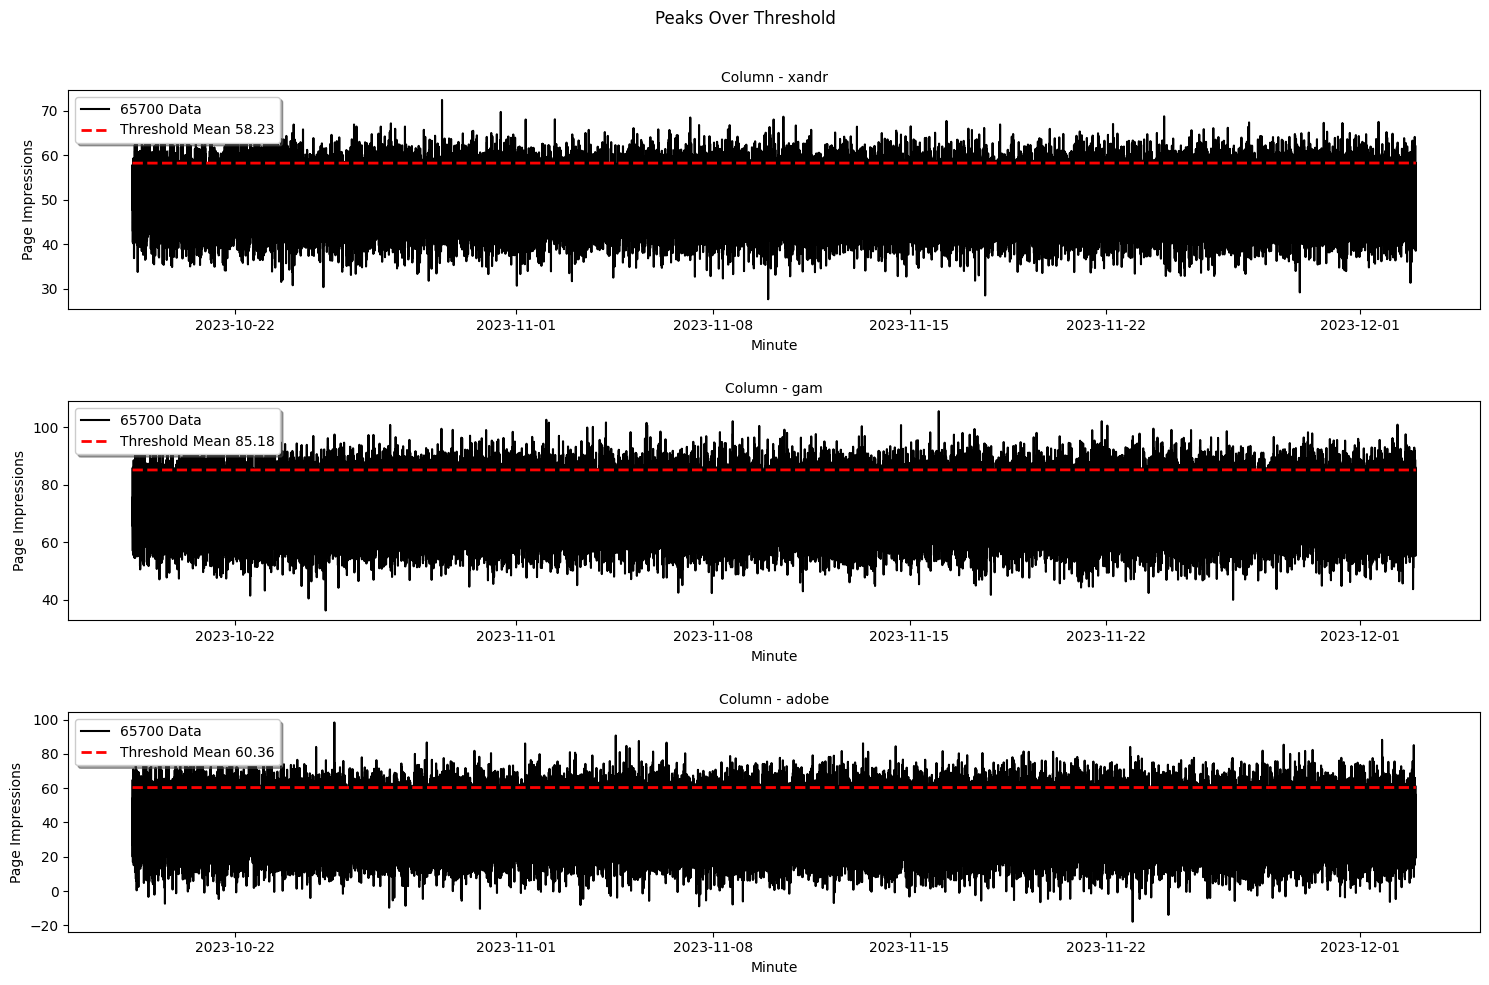

In [51]:
pot_detector.plot(ptype="line-exceedance-df", title="Peaks Over Threshold", xlabel="Minute", ylabel="Page Impressions", alpha=1.0)

<h1 id="fit"><strong>Fitting</strong></h1>

The fitting is implemented by using `scipy.stats.genpareto.fit()` combined with the dynamic accumulated data points as its argument:

$\text{Fitting Data }=T0+0,T+1,...,T+n$

The idea of fitting is to get the generalized pareto distirbution's parameters that will be used to calculate the survival function (p-value) of the distribution

$sf=1-CDF(\text{c}, \text{ loc}, \text{ scale})$

Before inverting it to get the **"Anomaly Score"**. Now depending whether you use a DataFrame or Series, we imeplement a different strategy as the optimization of the anomaly detection process.

In [52]:
pot_detector.fit()

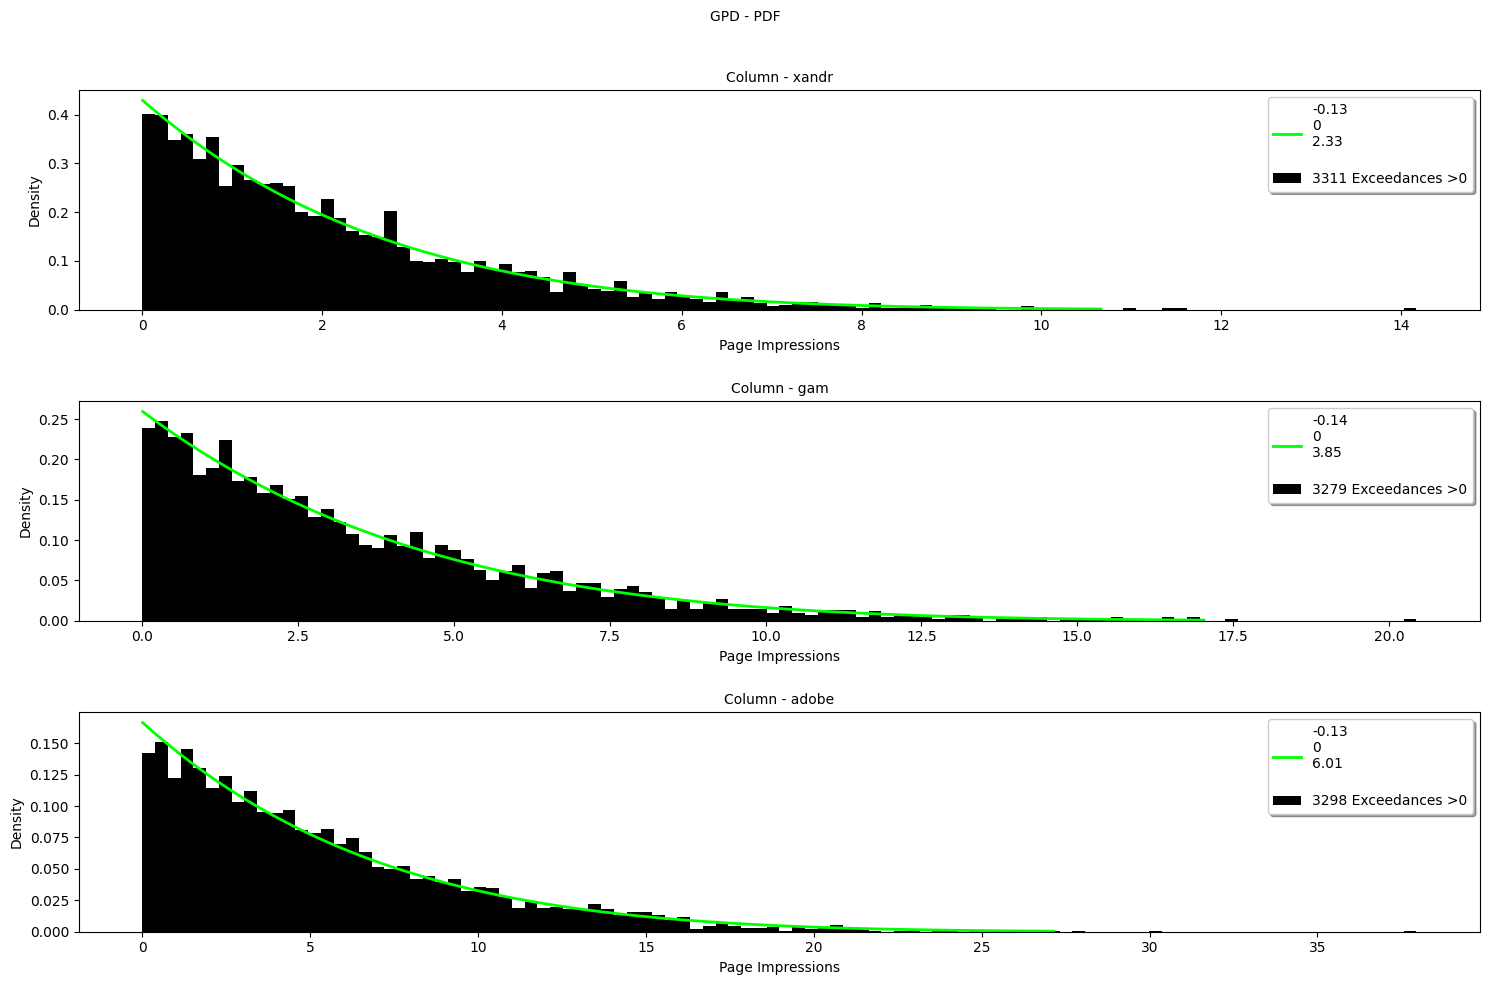

In [53]:
pot_detector.plot(ptype="hist-gpd-df", title="GPD - PDF", xlabel="Page Impressions", ylabel="Density", alpha=1.0, bins=100)

In [54]:
pot_detector.fit_result.head(20)

,xandr_anomaly_score,gam_anomaly_score,adobe_anomaly_score,total_anomaly_score,datetime
0,1.087147,0.000000,0.000000,1.087147,2023-11-17 00:46:00
1,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:47:00
2,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:48:00
3,0.000000,1.815875,0.000000,1.815875,2023-11-17 00:49:00
4,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:50:00
5,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:51:00
6,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:52:00
7,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:53:00
8,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:54:00
9,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:55:00


In [55]:
pot_detector.params

{0: {'xandr': {'c': -0.11675297447288158,
   'loc': 0,
   'scale': 2.3129766056305603,
   'p_value': 0.9198385927065513,
   'anomaly_score': 1.0871472537998},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'total_anomaly_score': 1.0871472537998},
 1: {'xandr': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'total_anomaly_score': 0.0},
 2: {'xandr': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
 

<h1 id="detection"><strong>The Detection</strong></h1>

If our dataset is a Pandas DataFrame, `anomalytics` provides an extra column in the anomaly score dataset (result of `fit()`) called `total_anomaly_score` which is the added anomaly scores from all columns in each row. This is to implement the Flu Group Theory (my favourite made up story by Alessandro to explain the optimization concept) which in the essence is as a lookup column whether the row has an anomaly or not. This column in T1 time window is the one used to calculate the anomaly threshold using NumPy quantile!

In [56]:
pot_detector.detect(0.95)

In [57]:
pot_detector.detection_result

16425    False
16426    False
16427    False
16428    False
16429    False
         ...  
22990    False
22991    False
22992    False
22993    False
22994    False
Name: detected data, Length: 6570, dtype: bool

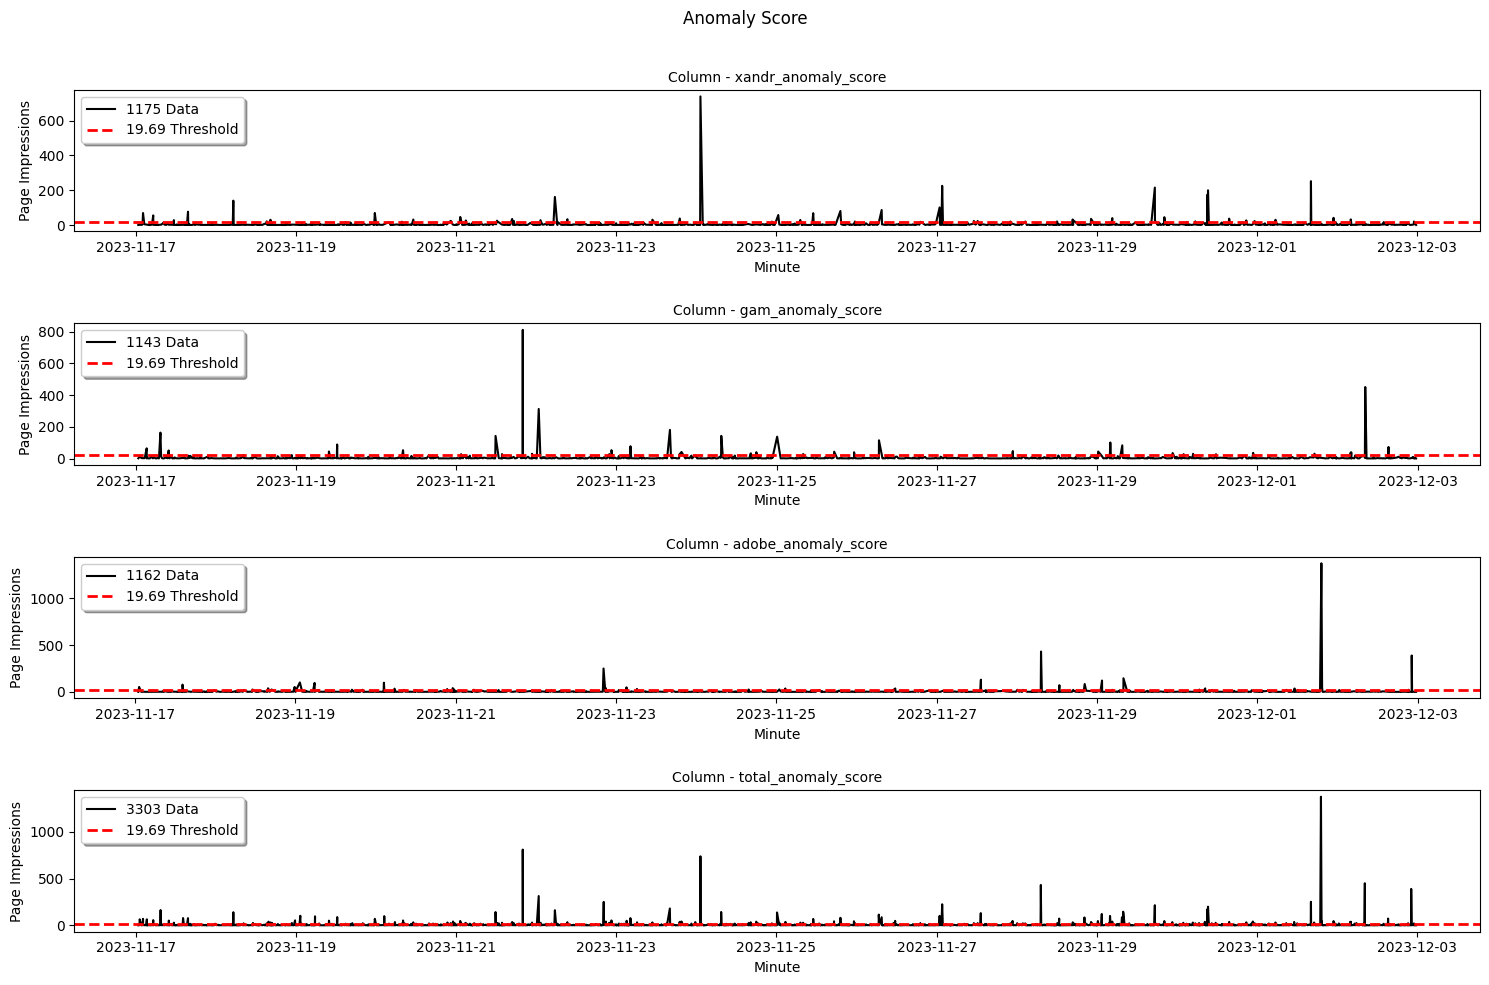

In [58]:
pot_detector.plot(ptype="line-anomaly-score-df", title="Anomaly Score", xlabel="Minute", ylabel="Page Impressions", alpha=1.0)

In [59]:
pot_detector.detected_anomalies

,row,xandr,gam,adobe,xandr_anomaly_score,gam_anomaly_score,adobe_anomaly_score,total_anomaly_score
16425,59130,43.646877,74.672586,26.002624,0.0,0.0,0.000000,0.000000
16426,59131,44.915313,82.171383,25.721367,0.0,0.0,0.000000,0.000000
16427,59132,44.224273,70.760384,28.992463,0.0,0.0,0.000000,0.000000
16428,59133,52.885331,49.505425,29.840008,0.0,0.0,0.000000,0.000000
16429,59134,44.250860,62.342018,62.484308,0.0,0.0,1.438367,1.438367
...,...,...,...,...,...,...,...,...
22990,65695,43.409608,81.528604,40.583620,0.0,0.0,0.000000,0.000000
22991,65696,55.431047,71.901495,29.129175,0.0,0.0,0.000000,0.000000
22992,65697,53.327388,75.215067,25.941889,0.0,0.0,0.000000,0.000000
22993,65698,50.001606,62.709613,46.138336,0.0,0.0,0.000000,0.000000


In [60]:
pot_detector.detection_summary

,row,xandr,gam,adobe,xandr_anomaly_score,gam_anomaly_score,adobe_anomaly_score,total_anomaly_score,anomaly_threshold
2023-11-28 12:06:00,59225,64.117135,76.425925,47.772929,21.445759,0.000000,0.000000,21.445759,19.689885
2023-11-28 12:25:00,59244,40.513415,94.526021,65.921644,0.000000,19.557962,2.685337,22.243299,19.689885
2023-11-28 12:45:00,59264,52.362039,54.191719,79.972860,0.000000,0.000000,72.313273,72.313273,19.689885
2023-11-28 16:48:00,59507,64.753203,70.344142,42.540168,32.543021,0.000000,0.000000,32.543021,19.689885
2023-11-28 16:53:00,59512,35.912221,52.572939,75.621003,0.000000,0.000000,22.199505,22.199505,19.689885
2023-11-28 17:01:00,59520,64.448182,67.633301,35.634080,26.518739,0.000000,0.000000,26.518739,19.689885
2023-11-28 20:19:00,59718,48.098003,78.124329,80.518135,0.000000,0.000000,84.895994,84.895994,19.689885
2023-11-28 22:18:00,59837,64.921170,71.633573,41.576428,36.264117,0.000000,0.000000,36.264117,19.689885
2023-11-29 00:21:00,59960,59.578678,96.495021,30.635908,1.827743,44.380590,0.000000,46.208334,19.689885
2023-11-29 01:31:00,60030,50.758677,71.893573,81.708607,0.000000,0.000000,122.139842,122.139842,19.689885


<h1 id="eval"><strong>Evaluation</strong></h1>

After the full flow of the detection process, we should have a way to confirm that all calculation method is executed correctly (in a cenrtain degree because I learn that statistics is almost like politics in the way that we can't actually answer any question directly 😜).

### Kolmogorov-Smirnov

The Kolmogorov-Smirnov statistic measures the maximum distance between the empirical distribution function of the sample and the cumulative distribution function of the reference (theoretical) distribution.

In simpler terms, it quantifies the largest discrepancy between the distribution of your sample data and the expected theoretical distribution. A larger stats_distance value indicates a greater difference between the two distributions, suggesting that the sample may not follow the theoretical distribution closely.

In [61]:
pot_detector.evaluate(method="ks")
pot_detector.evaluation_result

,column,total_nonzero_exceedances,stats_distance,p_value,c,loc,scale
0,xandr,3311,0.012901,0.635246,-0.128561,0,2.329005
1,gam,3279,0.011006,0.817674,-0.140479,0,3.852574
2,adobe,3298,0.019479,0.161510,-0.133019,0,6.007833


### QQ Plot

A QQ (quantile-quantile) plot is a graphical tool used to compare two probability distributions by plotting their quantiles against each other. If the two distributions being compared are similar, the points in the QQ plot will approximately lie on a straight line.

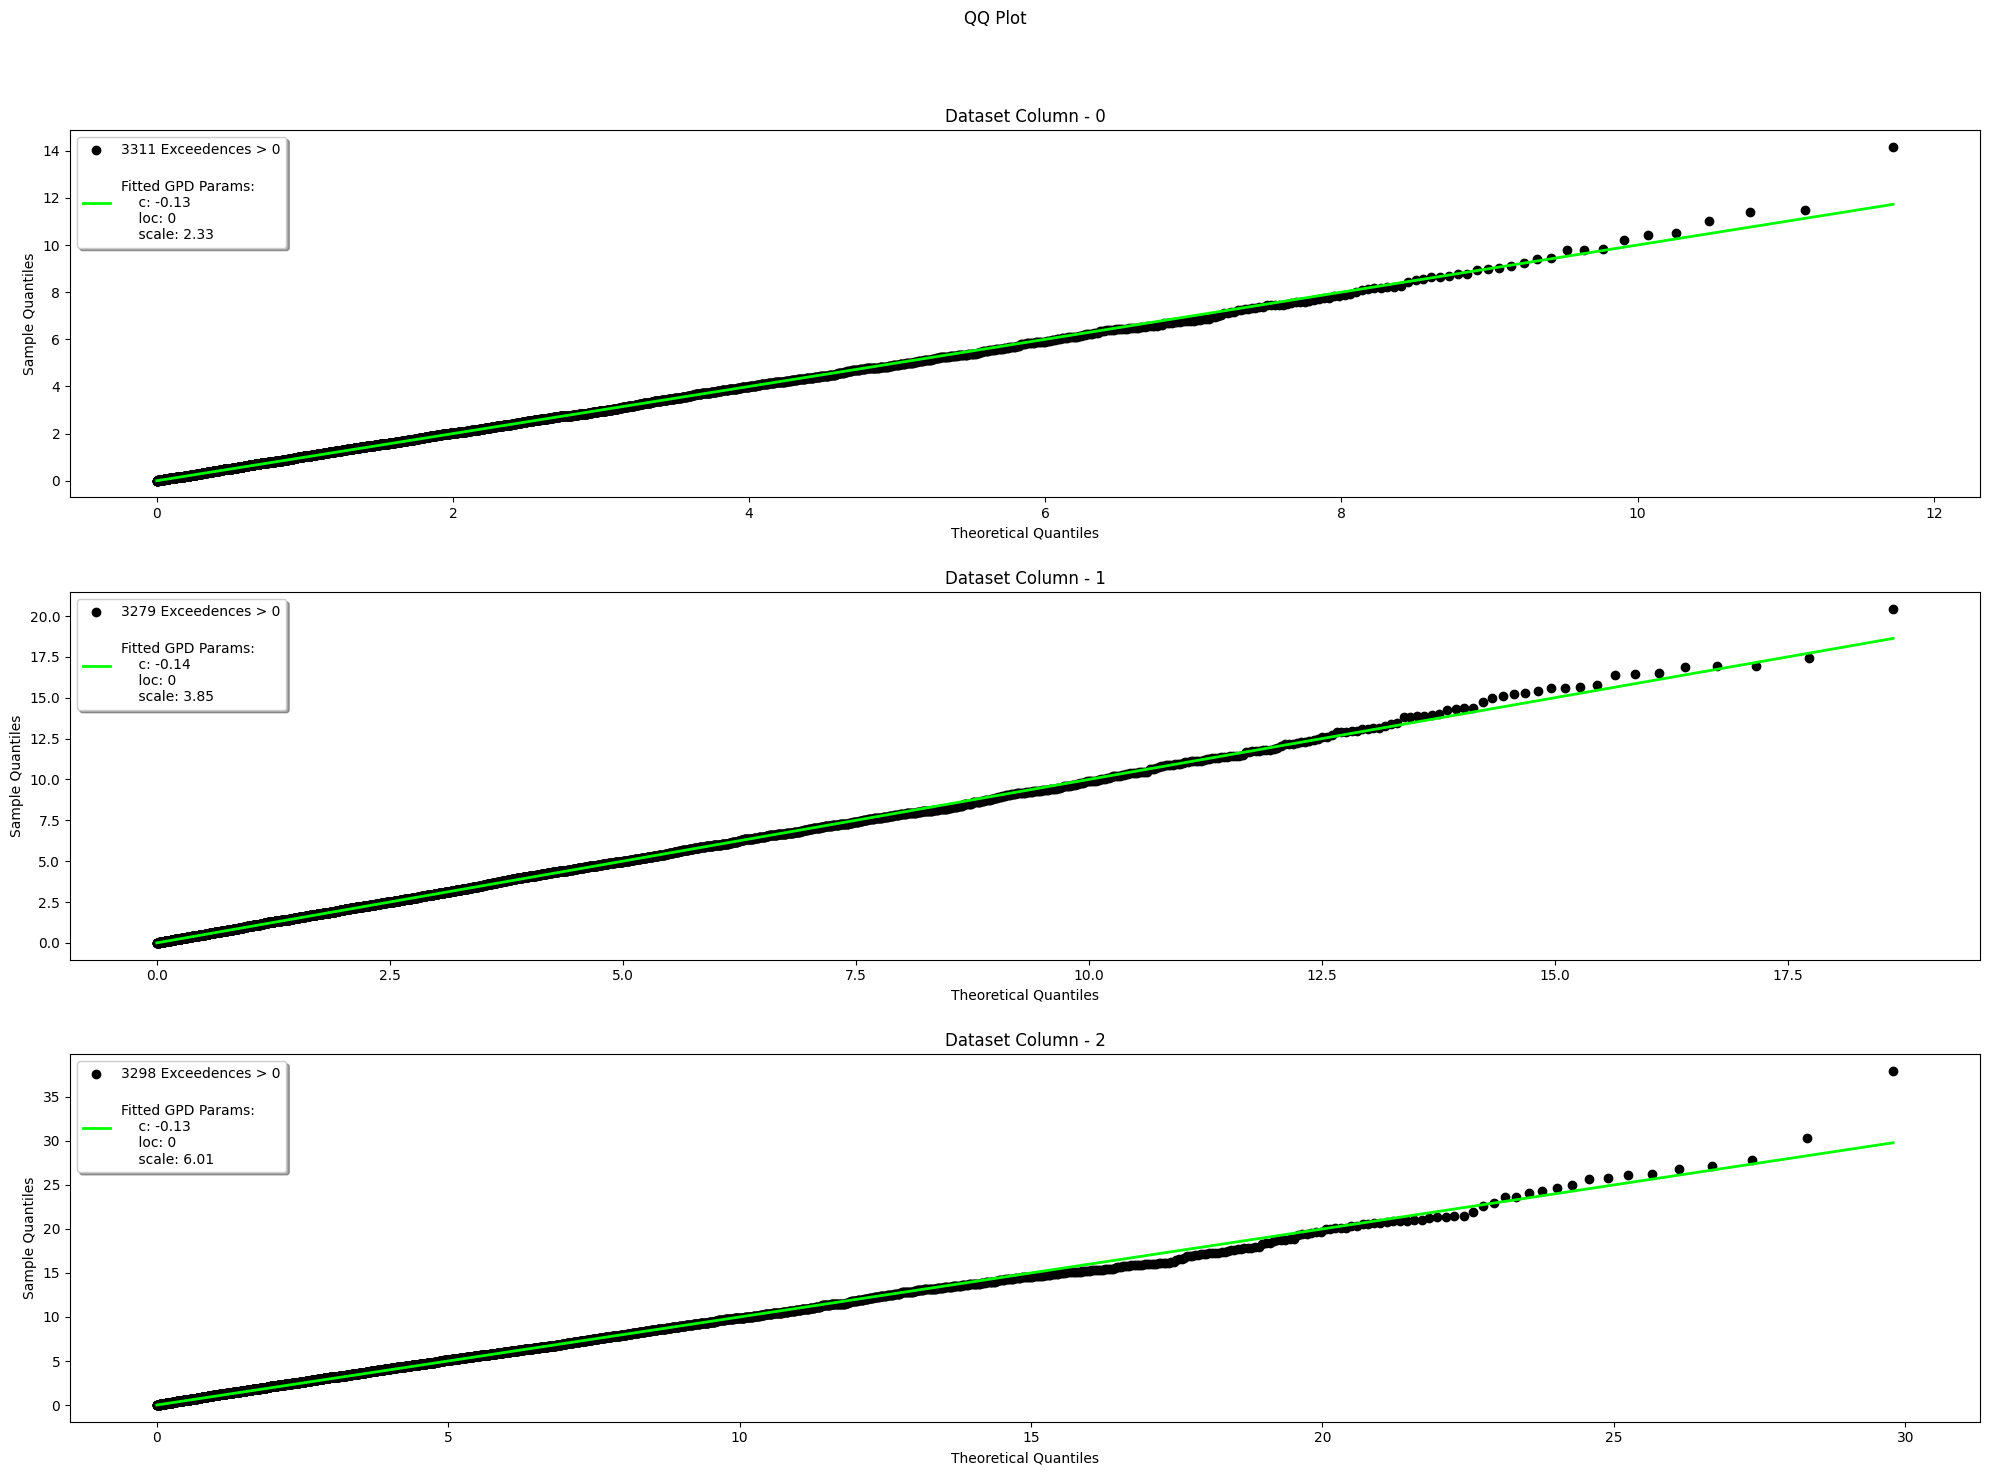

In [62]:
pot_detector.evaluate(method="qq")

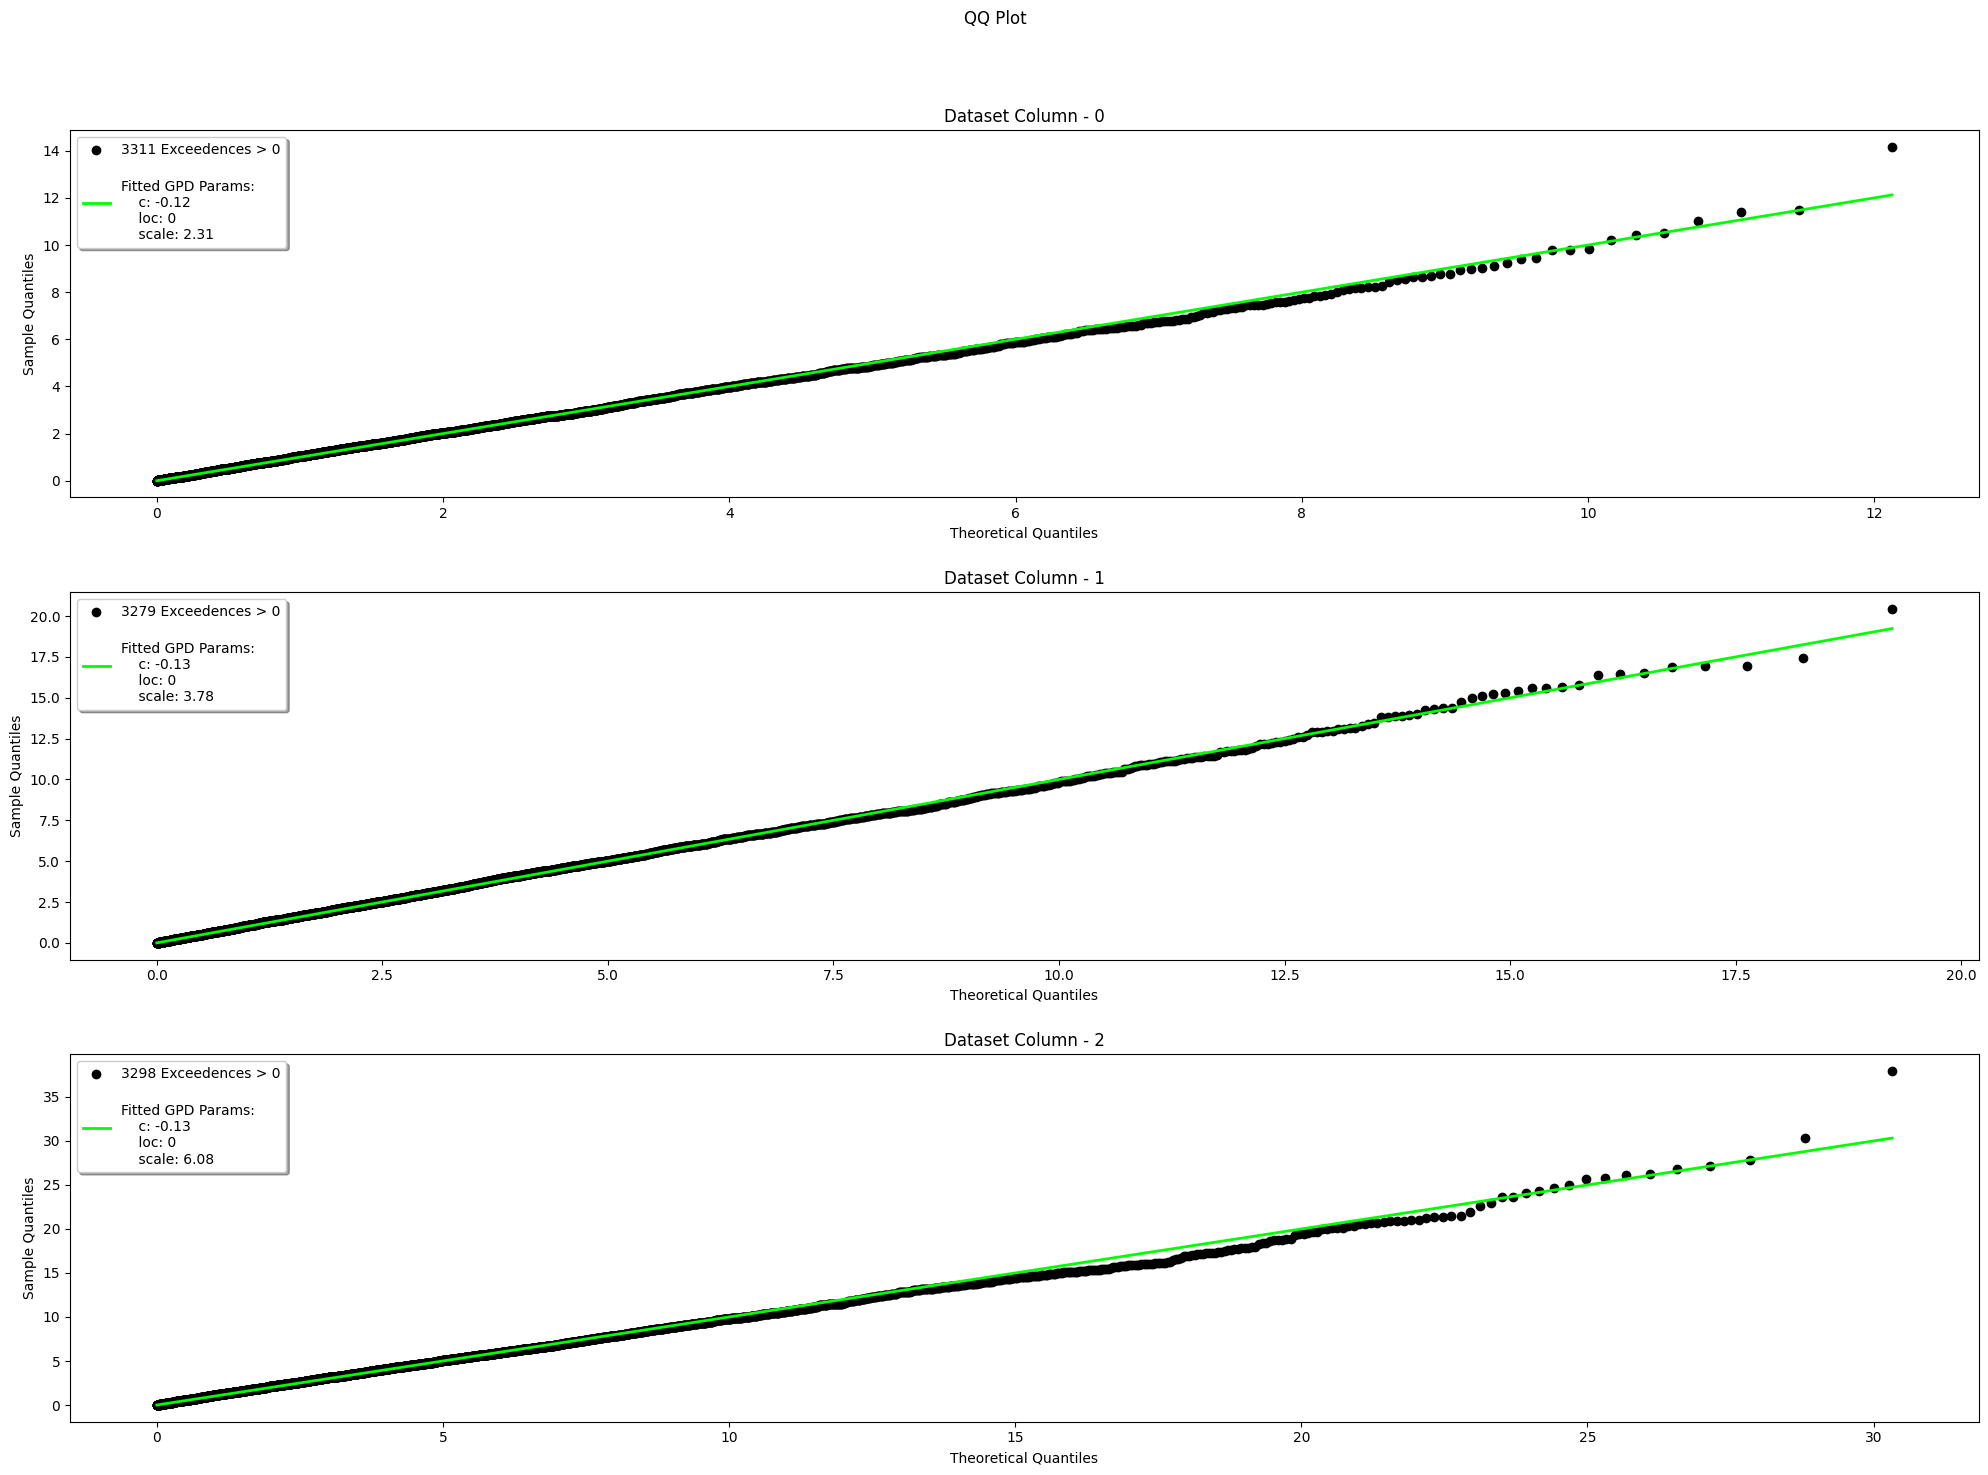

In [63]:
pot_detector.evaluate(method="qq", is_random_param=True)

<h1 id="notification"><strong>Send Notification!</strong></h1>

One of the real use case of an anomaly detection is the real time notification system. `anomalytics` provides a very easy and simple way to send notification to your team via Slack or any E-Mail provider.

P. S. Change the webhook URL or the email password to your own 😋

In [64]:
slack= atics.get_notification(platform="slack", webhook_url="https://hooks.slack.com/services/YOUR/SLACK/TOKEN")

In [65]:
slack.setup(detection_summary=pot_detector.detection_summary, message="Extremely large anomaly detected! from Ad Ipression Dataset!")

In [66]:
#slack.send

<h1 id="low-anomaly"><strong>Restart Detection for Extremely Low Anomalies</strong></h1>

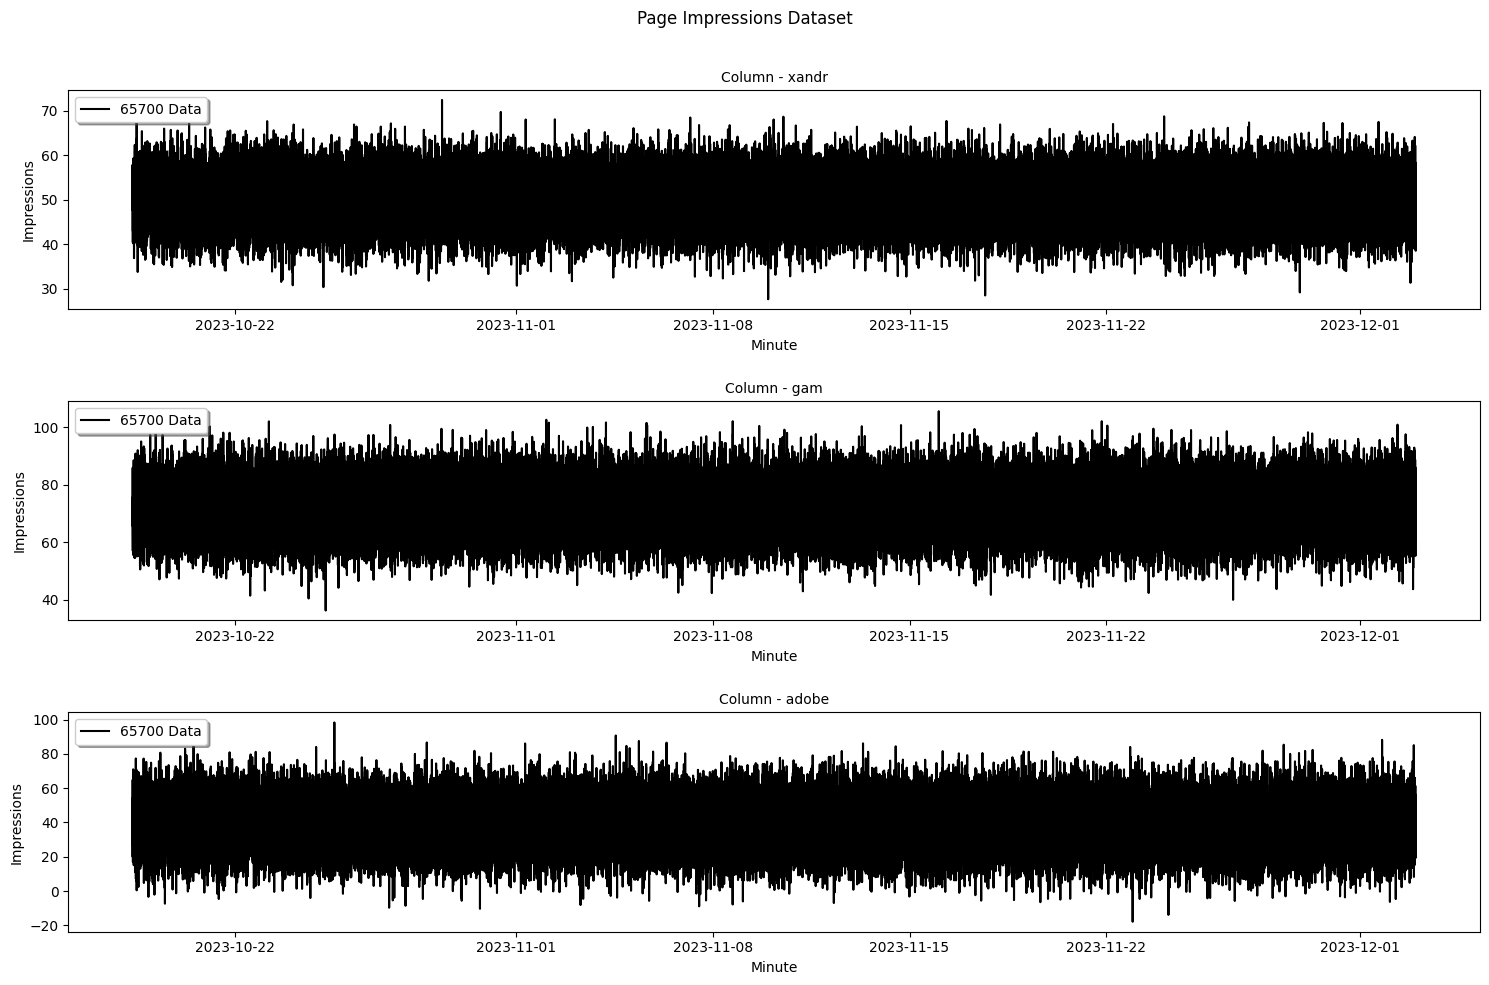

In [67]:
pot_detector = atics.get_detector(
    method="POT",
    dataset=df,
    anomaly_type="low"
)
pot_detector.plot(ptype="line-dataset-df", title=f"Page Impressions Dataset", xlabel="Minute", ylabel="Impressions", alpha=1.0)

In [68]:
pot_detector.reset_time_window(
    analysis_type="historical",
    t0_pct=0.65,
    t1_pct=0.25,
    t2_pct=0.1
)
print("T0:", pot_detector.t0)
print("T1:", pot_detector.t1)
print("T2:", pot_detector.t2)

T0: 42705
T1: 16425
T2: 6570


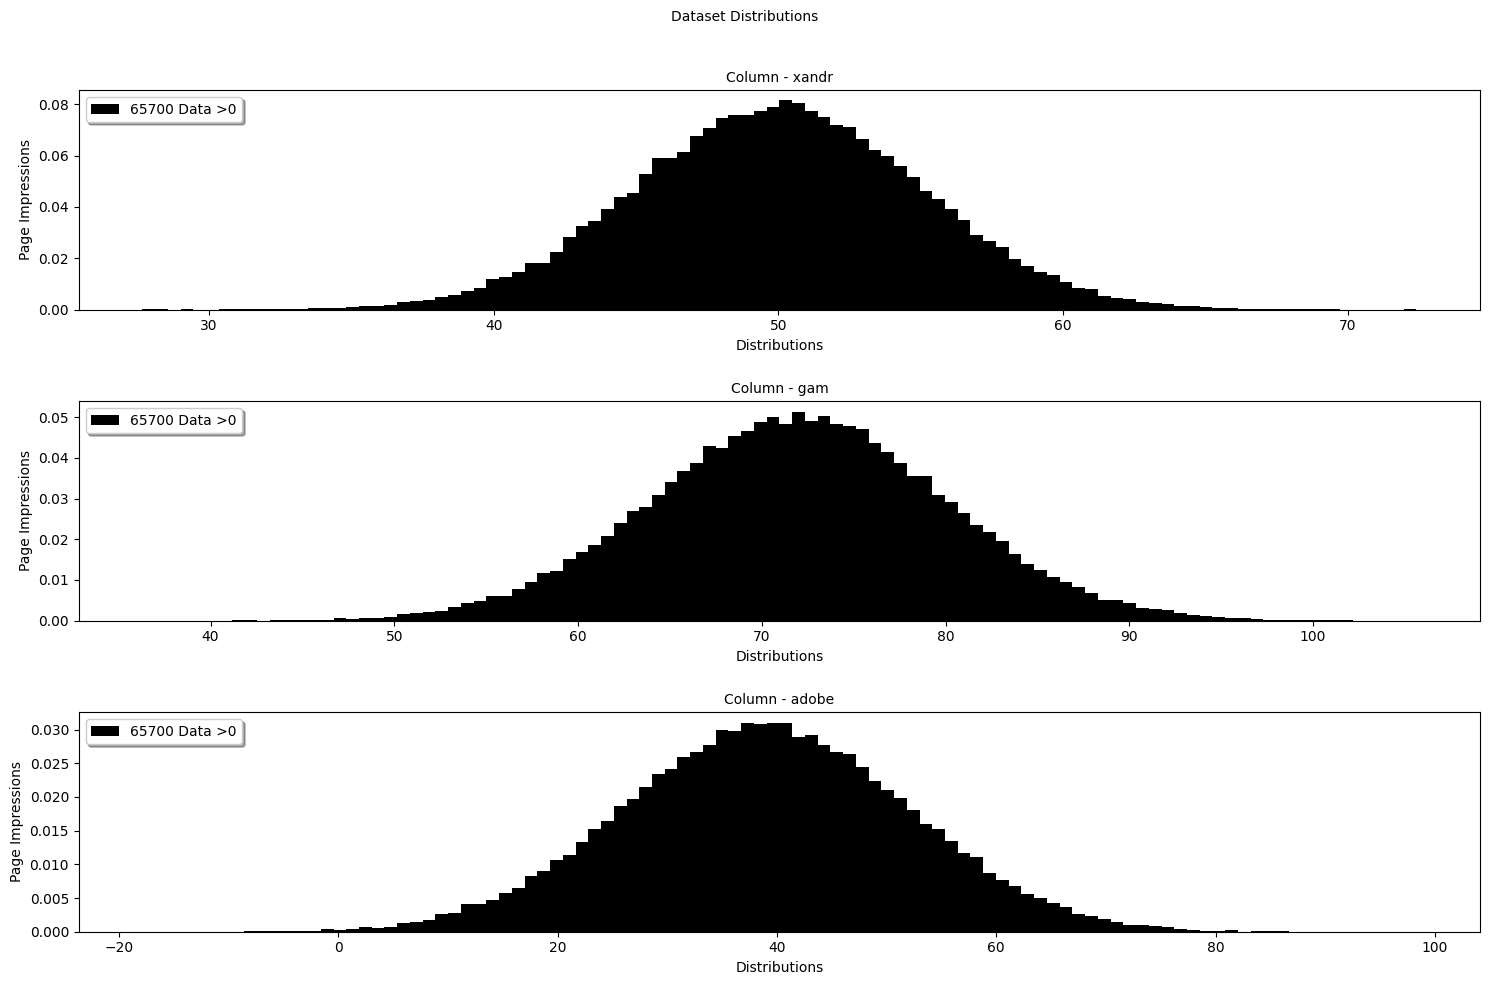

In [69]:
pot_detector.plot(ptype="hist-dataset-df", title="Dataset Distributions", xlabel="Distributions", ylabel="Page Impressions", alpha=1.0, bins=100)

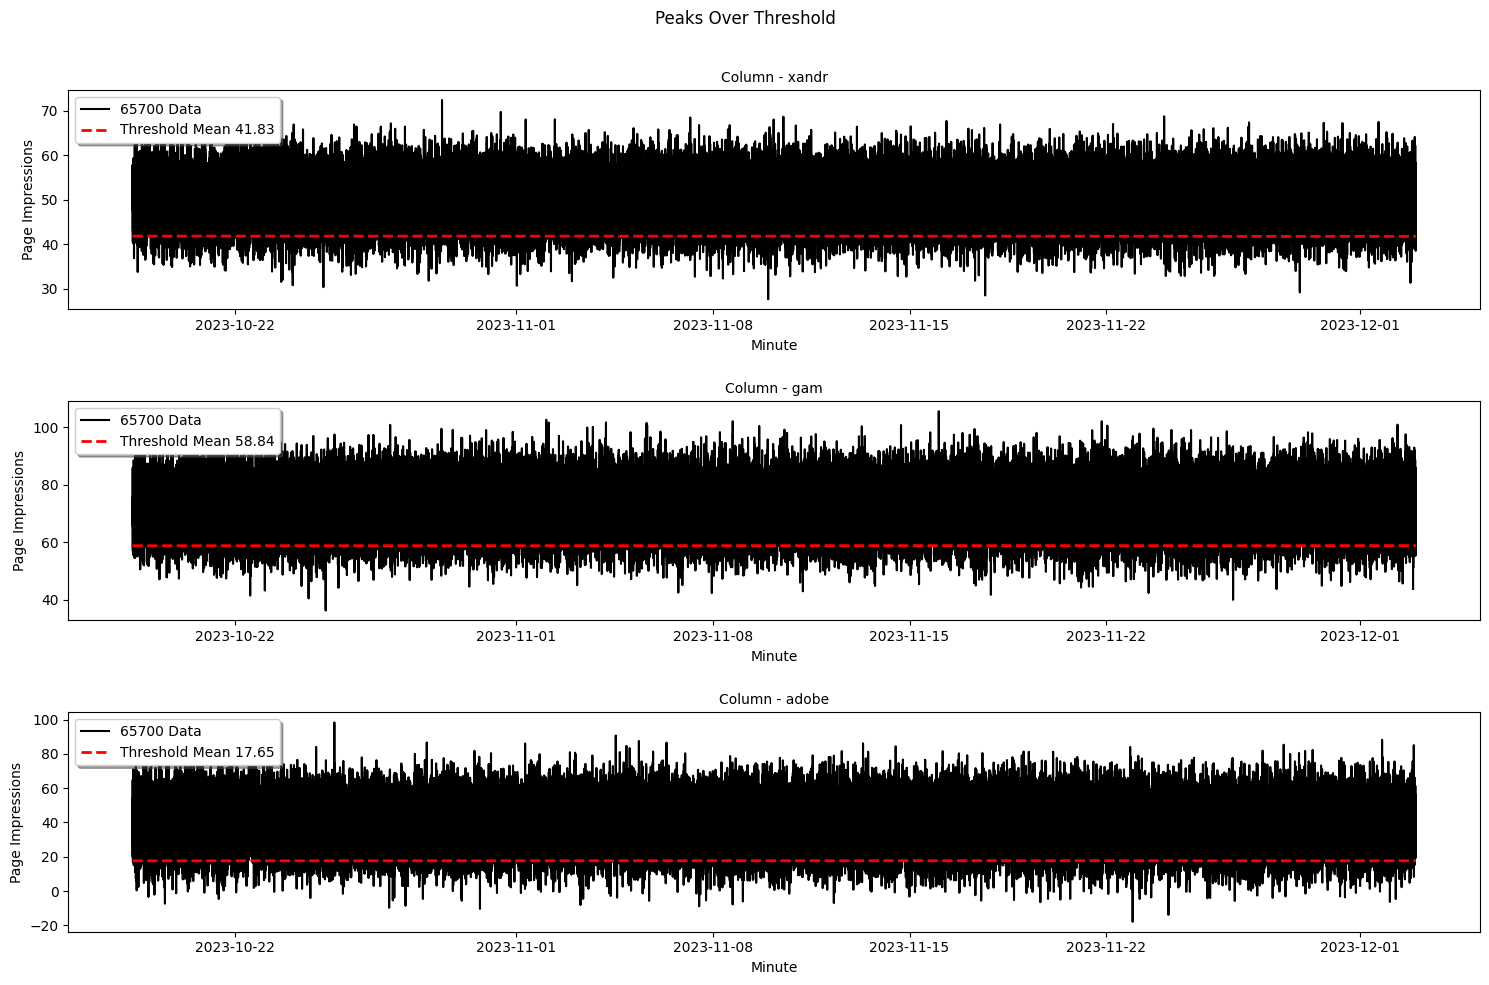

In [70]:
pot_detector.get_extremes(q=0.95)
pot_detector.exceedance_thresholds.head(20)
pot_detector.exceedances.head()

pot_detector.plot(ptype="line-exceedance-df", title="Peaks Over Threshold", xlabel="Minute", ylabel="Page Impressions", alpha=1.0)

In [71]:
pot_detector.fit()
pot_detector.fit_result.head(20)

,xandr_anomaly_score,gam_anomaly_score,adobe_anomaly_score,total_anomaly_score,datetime
0,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:46:00
1,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:47:00
2,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:48:00
3,0.000000,0.000000,1.618595,1.618595,2023-11-17 00:49:00
4,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:50:00
5,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:51:00
6,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:52:00
7,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:53:00
8,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:54:00
9,0.000000,0.000000,0.000000,0.000000,2023-11-17 00:55:00


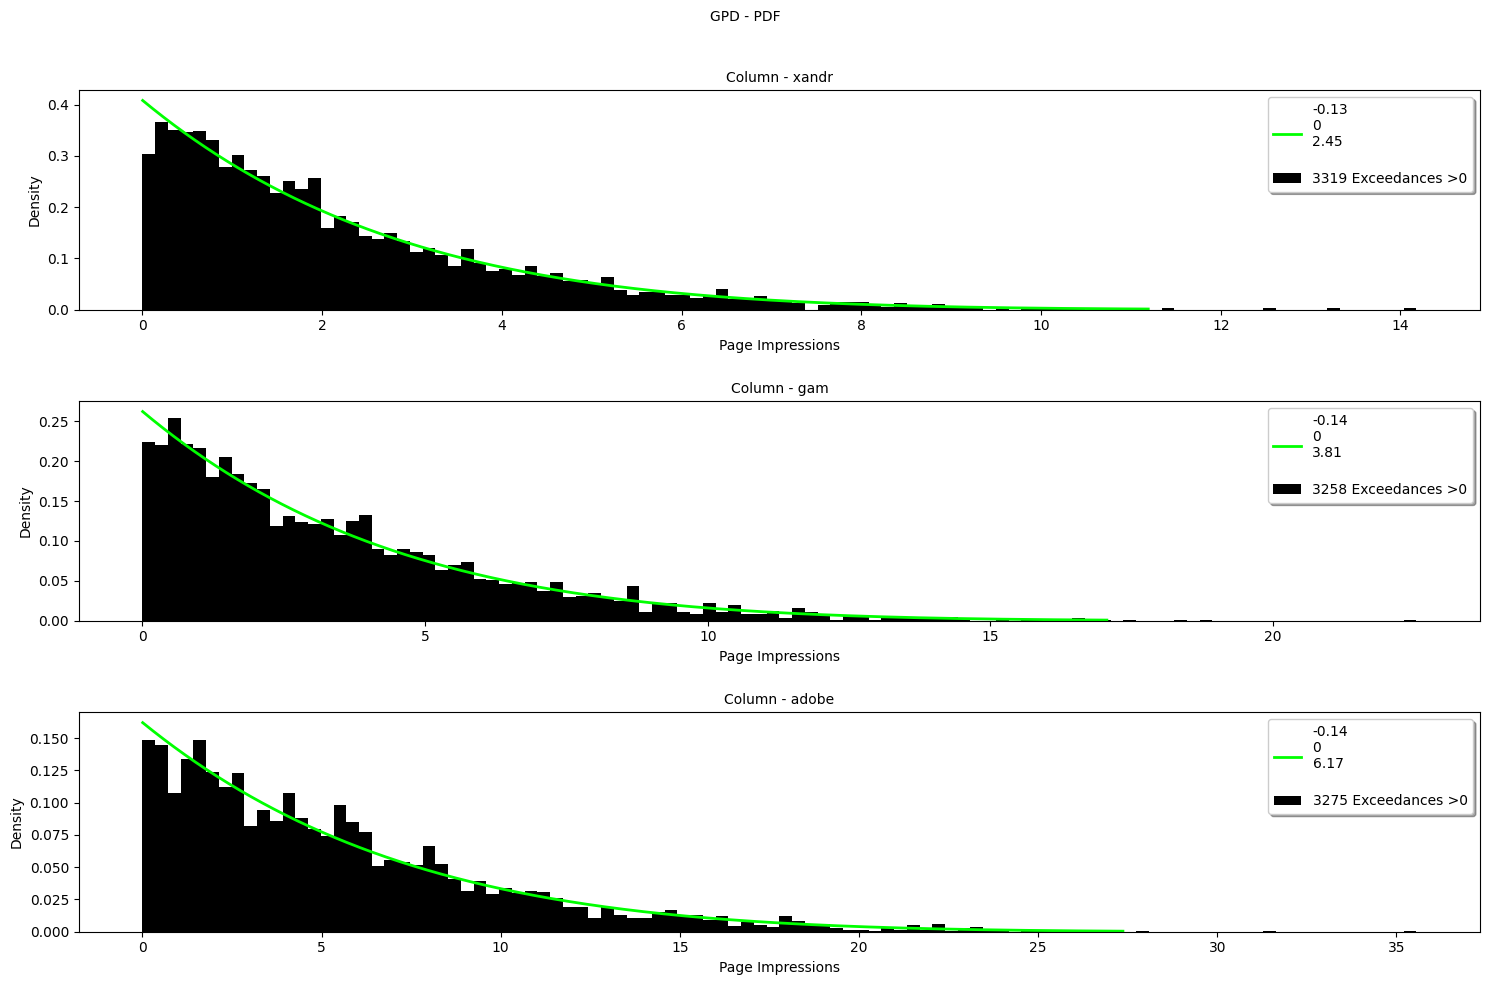

In [72]:
pot_detector.plot(ptype="hist-gpd-df", title="GPD - PDF", xlabel="Page Impressions", ylabel="Density", alpha=1.0, bins=100)

In [73]:
pot_detector.params

{0: {'xandr': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'total_anomaly_score': 0.0},
 1: {'xandr': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'total_anomaly_score': 0.0},
 2: {'xandr': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'gam': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'adobe': {'c': 0.0,
   'loc': 0.0,
   'scale': 0.0,
   'p_value': 0.0,
   'anomaly_score': 0.0},
  'total_anomaly_score': 0.0},
 3: {'xandr':

In [74]:
pot_detector.detect(0.95)
pot_detector.detection_result

16425    False
16426    False
16427    False
16428    False
16429    False
         ...  
22990    False
22991    False
22992    False
22993    False
22994    False
Name: detected data, Length: 6570, dtype: bool

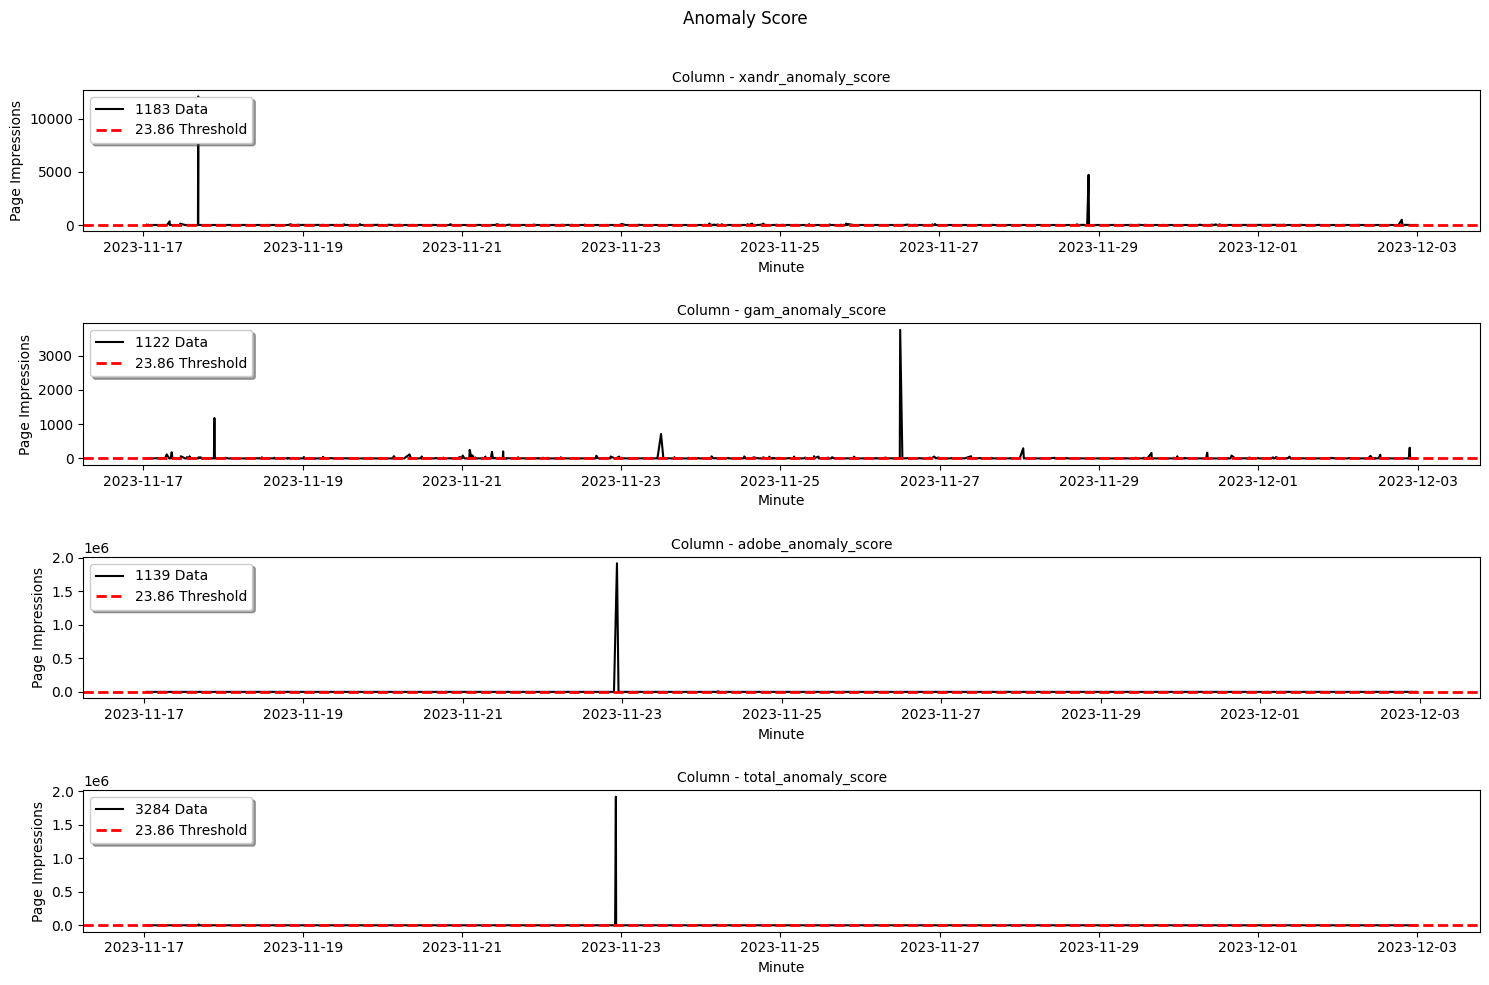

In [75]:
pot_detector.plot(ptype="line-anomaly-score-df", title="Anomaly Score", xlabel="Minute", ylabel="Page Impressions", alpha=1.0)

In [76]:
pot_detector.detection_summary

,row,xandr,gam,adobe,xandr_anomaly_score,gam_anomaly_score,adobe_anomaly_score,total_anomaly_score,anomaly_threshold
2023-11-28 16:53:00,59512,35.912221,52.572939,75.621003,17.476041,6.508338,0.000000,23.984379,23.861065
2023-11-28 17:28:00,59547,34.013234,66.701341,32.064514,58.936281,0.000000,0.000000,58.936281,23.861065
2023-11-28 21:00:00,59759,29.211331,63.476702,30.997606,4714.891925,0.000000,0.000000,4714.891925,23.861065
2023-11-29 01:50:00,60049,56.253407,64.902930,-1.446797,0.000000,0.000000,57.071168,57.071168,23.861065
2023-11-29 12:16:00,60675,35.459286,58.682416,38.649544,22.825079,1.050939,0.000000,23.876019,23.861065
2023-11-29 15:49:00,60888,48.700877,44.922651,22.934255,0.000000,161.038635,0.000000,161.038635,23.861065
2023-11-29 19:34:00,61113,35.757366,51.828322,14.615371,19.214140,8.493116,1.669975,29.377232,23.861065
2023-11-29 20:47:00,61186,51.001752,68.202439,0.668041,0.000000,0.000000,32.343058,32.343058,23.861065
2023-11-29 23:34:00,61353,45.435431,46.807812,42.181834,0.000000,63.411148,0.000000,63.411148,23.861065
2023-11-30 06:33:00,61772,34.787662,76.202198,49.952998,35.230493,0.000000,0.000000,35.230493,23.861065


In [77]:
pot_detector.evaluate(method="ks")
pot_detector.evaluation_result

,column,total_nonzero_exceedances,stats_distance,p_value,c,loc,scale
0,xandr,3319,0.022394,0.070587,-0.128704,0,2.446027
1,gam,3258,0.013509,0.586957,-0.135928,0,3.807834
2,adobe,3275,0.022846,0.064513,-0.139296,0,6.168533


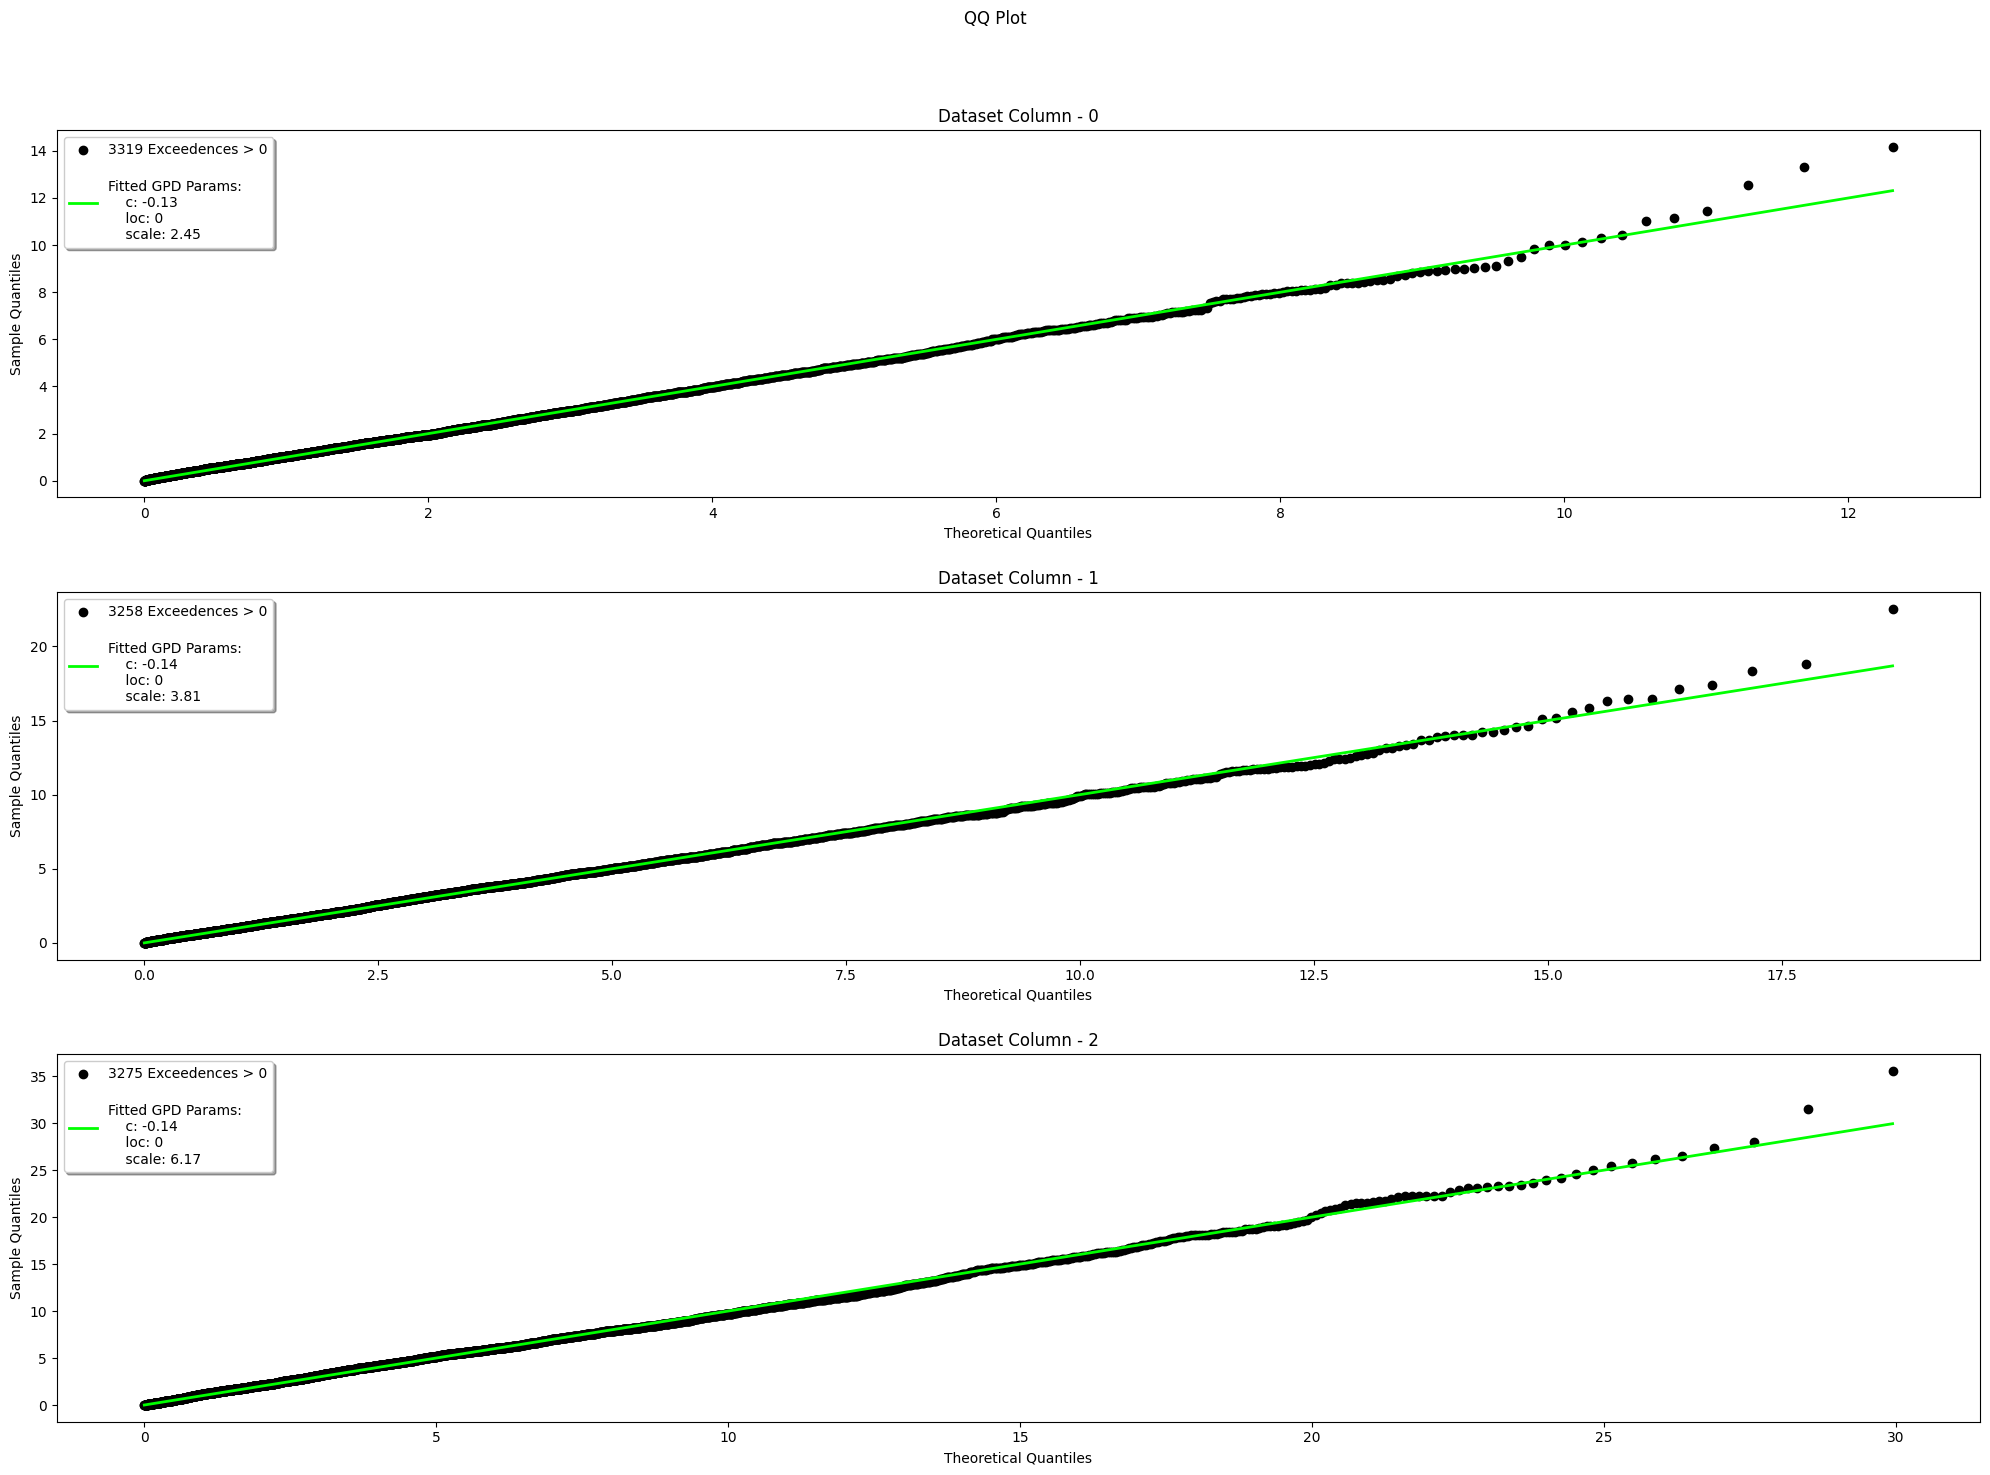

In [78]:
pot_detector.evaluate(method="qq")

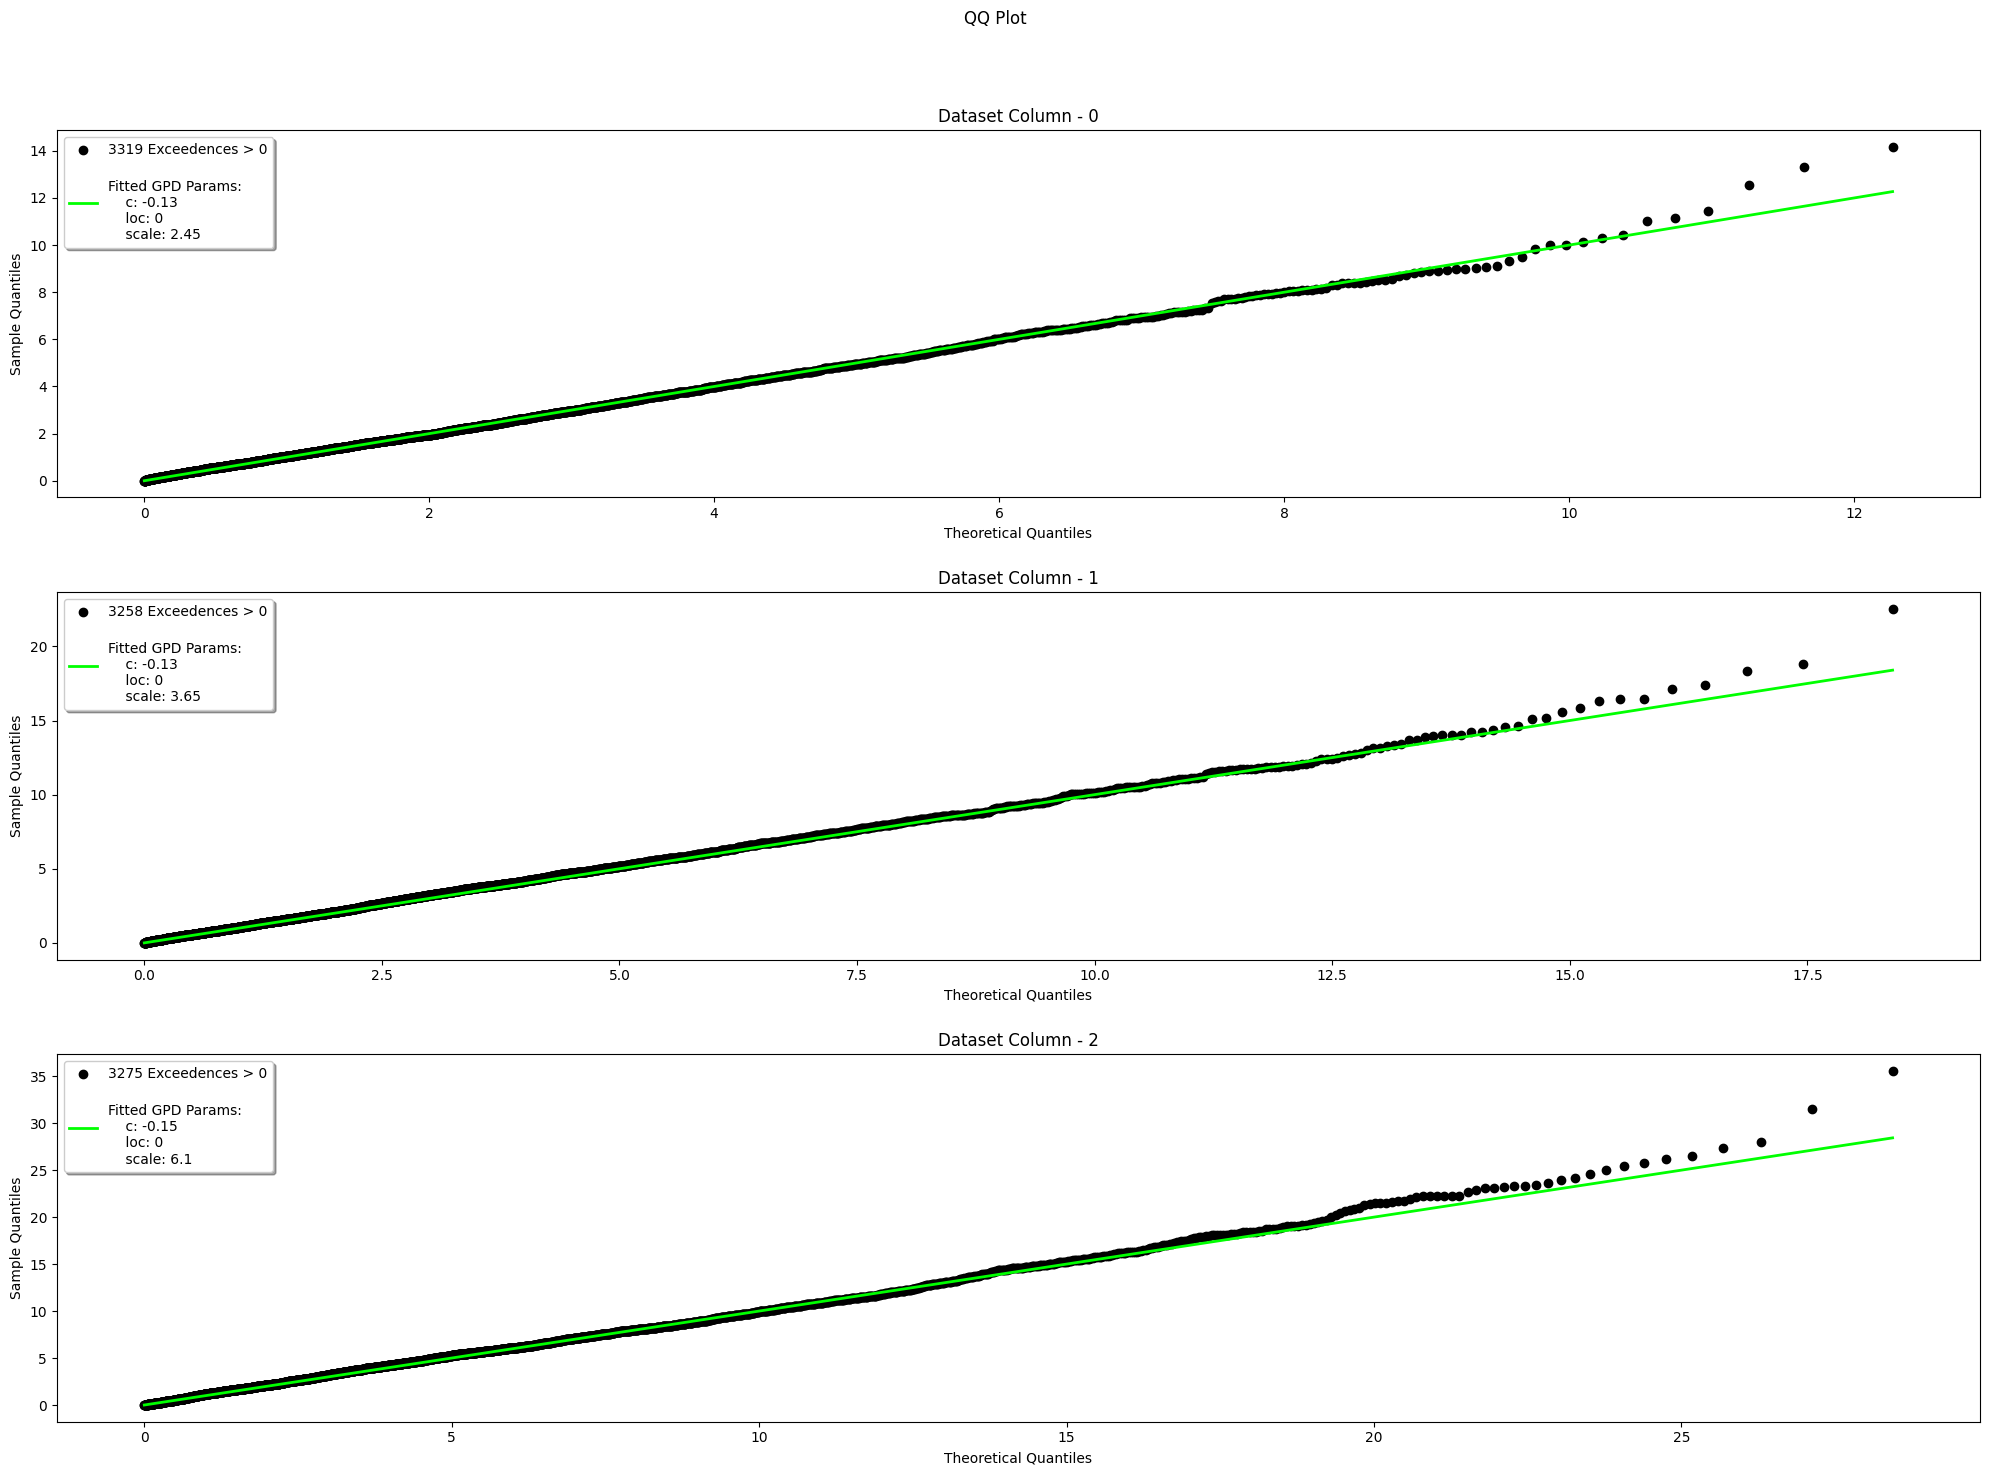

In [79]:
pot_detector.evaluate(method="qq", is_random_param=True)